# ASSIGNMENT 3 

#### Machine Learning in Korea University
#### COSE362, Fall 2018
#### Due : 12/18 (THU) 11:59 PM

#### In this assignment, you will implement and train a Recommender System. Also, you will learn how to utilize scikit-learn to analyze data using clustering.
* Implemented using Anaconda 5.3 with python 3.7. Please use <b>python 3</b>
* Use given dataset. Please do not change data split.
* Use numpy, scikit-learn, and matplotlib library
* You don't have to use all imported packages below. (some are optional). <br>
* <b>*DO NOT MODIFY OTHER PARTS OF CODES EXCEPT "Your Code Here"*</b>


### 1. Recommender System

In the problem 1, you will implement a simple recommender system.
* See your lecture note (Lecture 15. Recommender Systems - Collaborative filtering). 
* Do not implement matrix factorization and Do not import any other packages and libraries. <b>You should use only numpy</b>.
* Analyze train and validation error. <br>

### Dataset description : MovieLens Dataset


Here are brief descriptions of the data.

><b>u.data</b>     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC

><b>u1.base</b> -- Subset of u.data. You should use u1.base at training time. <br>
><b>u1.test</b> -- Subset of u.data. You should use u1.test at testing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1000)

In [2]:

with open('./data/u.info') as f:
    info = f.readlines()
    num_users = int(info[0].split()[0])
    num_movies = int(info[1].split()[0])

def read_data(file_name):
    with open('./data/' + file_name) as f:
        dataset = []
        cnt = 0
        while True:
            line = f.readline()
            if not line: break
            d = list(map(int, line.split()[:3]))
            d[0] -= 1
            d[1] -= 1
            dataset.append(d)
    return dataset

###########################################

train_dataset = read_data('u1.base')
valid_dataset = read_data('u1.test')


### 1 - (1) Design your recommender system model.

##### Instructions <br>
* <b>\__init\__</b> : configure model. <b>DO NOT MODIFY</b>.
* <b>compute_loss</b> : compute loss between user i and movie j.
* <b>update</b> : update the parameter of user i and movie j with gradient descent.
* <b>run_epoch</b> : train one iteration of collaborative filtering. <b>If "trainable=False", this function doesn't update parameters.</b> <br>
<t>The variable "trainable" is false when the model is on validation or test.
    

<br>* <b>loss</b> --> see your lecture note.
<br>* <b>rmse</b> indicates Root Mean Square Error that is widely used for rating prediction evaluation.

In [3]:

class RecommenderSystem():
    def __init__(self, num_users, num_movies, user_size, movie_size, learning_rate, reg_coef):
        self.user_mat = np.random.normal(0, 1, (num_users, user_size))
        self.movie_mat = np.random.normal(0, 1, (num_movies, movie_size))
        self.learning_rate = learning_rate
        self.reg_coef = reg_coef
        self.loss = 0.0
    
    def compute_loss(self, i, j, rating):
        # i: user / j: movie / rating
        target = 0
        if np.isnan(rating):
            loss = 0
        else:
            y_true = rating
            y_pred = self.user_mat[i].dot(self.movie_mat[j])
            loss = y_pred - y_true
        return target, loss
        
    def update(self, target, i, j, rating):
        # Compute
        target, loss = self.compute_loss(i, j, rating)
        user_temp = self.user_mat[i] - self.learning_rate * (loss * self.movie_mat[j] + self.reg_coef * self.user_mat[i])
        movie_temp = self.movie_mat[j] - self.learning_rate * (loss * self.user_mat[i] + self.reg_coef * self.movie_mat[j])
        # Update
        self.user_mat[i] = user_temp
        self.movie_mat[j] = movie_temp
        ##

    def run_epoch(self, dataset, trainable=False):
        loss_sum = rmse_sum = target_sum = 0
        np.random.shuffle(dataset)
        for s_idx, sample in enumerate(dataset):
            target, loss = self.compute_loss(sample[0], sample[1], sample[2])
            # If "trainable=False", this function doesn't update parameters. 
            if trainable:
                self.update(target, sample[0], sample[1], sample[2])
            else:
                pass
            loss_sum += np.absolute(loss)
            rmse_sum += loss**2
        rmse = np.sqrt(rmse_sum / len(dataset))
        return loss_sum / len(dataset), rmse

    

In [4]:

def main(config):
    #####
    # optimal : (int) the epoch where validation loss is minimum
    # eps : (list) a list of training epochs
    # loss_tr : (list) a list of training losses
    # loss_va : (list) a list of validation losses
    # rmse_tr : (list) a list of training rmse(root mean square error)
    # rmse_va : (list) a list of validation rmse(root mean square error)
    
    model = RecommenderSystem(num_users, num_movies,
                            config['user_size'],
                             config['movie_size'],
                             config['learning_rate'],
                             config['reg_coef'])
    
    min_loss = optimal = 99999
    eps, loss_tr, loss_va, rmse_tr, rmse_va  = [], [], [], [], []
    for epoch in range(config['max_epoch']):
        # ls_tr : mean of total losses in an epoch
        # e_tr : mean of total root mean square errors in an epoch
        ls_tr, e_tr = model.run_epoch(train_dataset, trainable=True)
        ls_va, e_va = model.run_epoch(valid_dataset, trainable=False)
        
        eps.append(epoch) # eps
        loss_tr.append(ls_tr) # loss_tr
        loss_va.append(ls_va) # loss_va
        rmse_tr.append(e_tr) # rmse_tr
        rmse_va.append(e_va) # rmse_va
        if ls_va < min_loss:
            optimal = epoch # optimal
    return optimal, eps, loss_tr, loss_va, rmse_tr, rmse_va, model

###################################################################

config = {'user_size': 10,
         'movie_size': 10,
         'learning_rate': 0.01,
         'reg_coef': 0.001,
         'max_epoch': 50,
         'eval_step': 5}

optimal, eps, loss_tr, loss_va, rmse_tr, rmse_va, model = main(config)
print ("\[Exp have been finished !]\nOptimal : {}, Train loss : {:2.3f}, Valid loss : {:2.3f}, RMSE : {:3.2f}"
       .format(optimal, loss_tr[optimal], loss_va[optimal], rmse_va[optimal]))

\[Exp have been finished !]
Optimal : 49, Train loss : 0.610, Valid loss : 0.851, RMSE : 1.13


### 1 - (2) Plot the training and validation loss against epochs and Analyze.
 


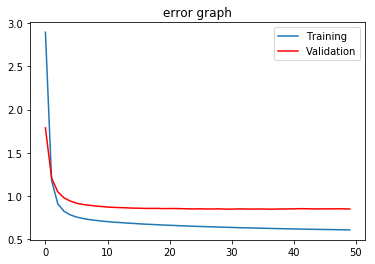

In [5]:
plt.plot(eps, loss_tr, eps, loss_va, 'r-')
plt.title("error graph")
plt.legend(["Training", "Validation"])
plt.show()


##### Analyze the result.

##### Write description here
1. Stochastic gradient descent 방법으로 update하기 때문에, 그리고 run_epoch 함수가 train_dataset에 대해서 먼저 호출되고 그 다음 valid_dataset에 대해 호출되기 때문에 첫 epoch에 대한 결과는 train_loss가 아주 높게 나타나고 valid_loss는 그 보다는 낮은 수치를 기록한다
2. epoch가 진행되어갈수록 train_loss와 valid_loss는 모두 점점 작아진다.
3. valid_dataset에 대해서는 학습하지 않기 때문에 valid_loss는 train_loss보다 전체적으로 좀 더 높은 수치를 보인다.
4. train_dataset에 대해서 모델이 계속 학습하기 때문에 train_loss는 꾸준히 눈이 보이는 수치 만큼 씩 감소하지만 valid_loss는 어느 정도 수준에 이르러서는 그 이후의 변화가 미미해진다. (epoch가 50보다 더 진행된다면 train_dataset에 너무 fitting되어서 valid_loss는 오히려 다시 증가할 것으로 예상된다.)
5. Optimal_epoch에서 train_loss와 valid_loss는 모두 낮은 수치를 기록하고 있고 그 차이도 1이하로 작기 때문에 overfit / underfit 되지 않은 적절히 학습된 모델이라고 볼 수 있다.

## 2. Clustering

In the problem 2, you would learn how to analyze data with unsupervised learning algorithm.
* Implement <b>k-means clustering</b> algorithm using <b>scikit-learn packages</b>. <br>
* Visualize your result and analyze. <br>
* Implement <b>PCA(principle component analysis)</b> and visualize your data onto 2-dimensional domain, and visualize your data by class-labels.

In [6]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn import cluster
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

n_samples = 3000
random_state = 1182
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

### 2 - (1) Implement K-means clustering algorithm and visualize data with class labels.
For given data, find the best number of clusters (each cluster is well-divided). <br>
Visualize your results using <b>scatter plot</b>. 

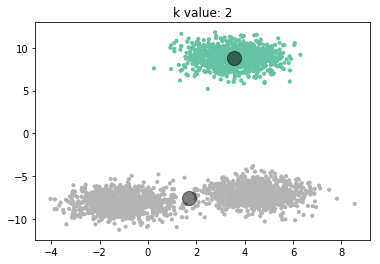

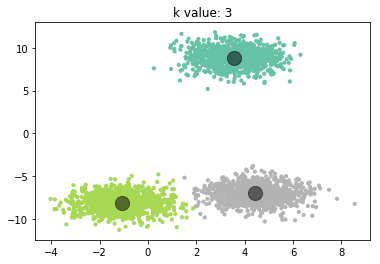

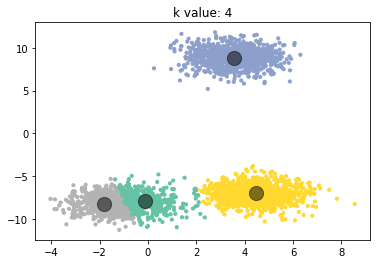

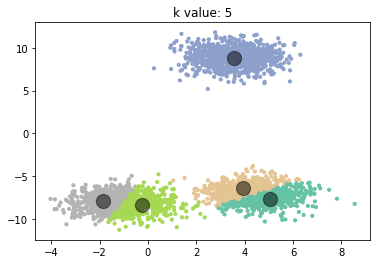

In [22]:
# Use sklearn.cluster.KMeans for k-means clustering
# Use plt.scatter for visualization

color_map = ['#20b2aa', '#ff7373', '#005073', '#da8c49', '#ffff66', '#1b9e77', '#7d6363', '#912727', '#d95f02', '#7570b3']
for k_value in range (2, 6):
    max_iter = 300    
    km = KMeans(n_clusters=k_value,
                max_iter=max_iter)
    km.fit(X)
    y_predict = km.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_predict, cmap='Set2', s=10);

    centers = km.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    plt.title("k value: "+ str(k_value))
    plt.show()

### 2 - (2) Implement PCA and visualize data with class labels.
Conduct K-means clustering on given data. <br>
Implement <b>PCA(principle component analysis)</b> to convert high-dimensional vectors into 2-dimensional vectors. <br>
Compare plots by K-means result and class labels by visualization. <br>
* Dataset : Handwritten digit dataset (Class : digit, Data : digit image)
* Visualize <b>two scatter plots</b>. (One for class label and one for k-means clustering)

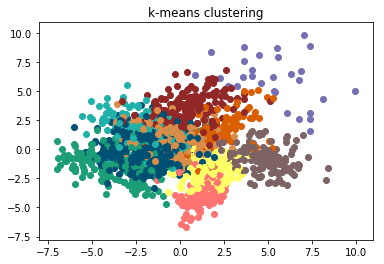

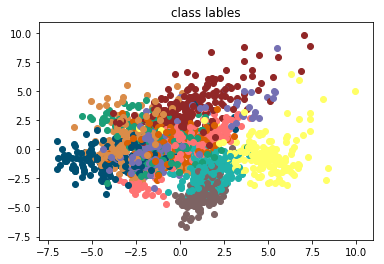

In [24]:
# use sklearn.decomposition.PCA

digits = load_digits()
data = scale(digits.data)
labels = digits.target

#PCA
pca_num = 2
reduced_feature = PCA(n_components=pca_num).fit_transform(data)

# Visualization function
color_map = ['#20b2aa', '#ff7373', '#005073', '#da8c49', '#ffff66', '#1b9e77', '#7d6363', '#912727', '#d95f02', '#7570b3']
def pca_visualize(k_value, labels, title):
    fig, ax = plt.subplots()
    for index, instance in enumerate(reduced_feature):
        color_map__ = color_map[0:k_value]
        pca_axis_1, pca_axis_2 = reduced_feature[index]
        color = color_map__[labels[index]]
        ax.scatter(pca_axis_1, pca_axis_2, c=color)
    plt.title(title)
    plt.show()
    
# KMeans
k_value = 10
max_iter = 300
clustering_model = KMeans(
    n_clusters=k_value,
    max_iter=max_iter,
    precompute_distances="auto",
    n_jobs=-1
)
y_km = clustering_model.fit_predict(data)
y_true = labels # class labels

pca_visualize(k_value, y_km, "k-means clustering")
pca_visualize(k_value, y_true, "class lables")